# Predicting course evaluations with Decision Trees


## 1. CART Algorithm Implementation

### 1.1. Tree data structure and helpers

In [2]:
class DecisionNode:
    def __init__(self, col=-1, value=None, results=None, tb=None, fb=None):
        self.col = col # attribute on which to split
        self.value = value # value on which to split
        self.results = results # If the node has no children - we store here class labels with their counts
        self.tb = tb  # True branch
        self.fb = fb  # False branch
        
def split(rows, column, value):
    # define split function according to the value type
    split_function = None
    if isinstance(value, int) or isinstance(value, float):
        split_function = lambda row: row[column] >= value
    else:
        split_function = lambda row: row[column] == value

    # Divide the rows into two sets and return them
    set1 = [row for row in rows if split_function(row)]
    set2 = [row for row in rows if not split_function(row)]
    return (set1, set2)

def count_labels(rows):
    label_count = {}
    for row in rows:
        # The class label is in the last column
        label = row[- 1]
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1
    return label_count

### 1.2. Node purity scores

In [3]:
from math import log

def gini_impurity(rows):
    total = len(rows)
    counts = count_labels(rows)
    gini = 0
    for key, val in counts.items():
        p = val / total
        gini += p*p
        
    return (1 - gini)

def entropy(rows):
    total = len(rows)
    counts = count_labels(rows)
    ent = 0.0
    for key,val in counts.items():
        p = val / total
        ent = ent - p * log(p, 2)
    return ent


def variance(rows):
    if len(rows) == 0: return 0
    num_label = [float(row[- 1]) for row in rows]
    mean = sum(num_label) / len(num_label)
    variance = sum([(d - mean) ** 2 for d in num_label]) / len(num_label)
    return variance


### 1.3. Tree induction

In [4]:
def buildtree(rows, score_func=entropy, min_improvement=0, min_samples=0, max_depth=None, depth=0):
    if len(rows) == 0:
        return DecisionNode()
    # Compute overall score for the entire rows dataset
    current_score = score_func(rows)

    # Set up accumulator variables to track the best split criteria
    best_score = current_score
    best_criteria = None
    best_sets = None
    
    # Total number of features - except the last column where we store the class (target)
    column_count = len(rows[0]) - 1 
    for col in range(0, column_count):
        # Generate the list of unique values in
        # this column to split on them
        column_values = set()
        for row in rows:
            column_values.add(row[col])
            
        # Now try splitting the rows 
        # on each unique value in this column
        for value in column_values:
            (set1, set2) = split(rows, col, value)

            # Evaluate the quality of the split
            # p is the proportion of subset set1 
            p = float(len(set1)) / len(rows)
            split_score = p * score_func(set1) + (1-p) * score_func(set2)
            
            if split_score < best_score and \
                (len(set1) > min_samples and len(set2) > min_samples) and \
                (current_score - split_score) > min_improvement:
                best_score = split_score
                best_criteria = (col, value)
                best_sets = (set1, set2)

    # Create the sub branches
    if (current_score - best_score) > min_improvement and \
        (max_depth is None or depth < max_depth) :
        # print("Splitting on",best_criteria, " 2 sets:", len(best_sets[0]),len(best_sets[1]))
        true_branch = buildtree(best_sets[0], score_func, min_improvement, min_samples, max_depth, depth+1)
        false_branch = buildtree(best_sets[1], score_func, min_improvement, min_samples, max_depth, depth+1)
        return DecisionNode(col=best_criteria[0], value=best_criteria[1],
                            tb=true_branch, fb=false_branch)
    else: # Done splitting - summarize class labels in leaf nodes
        return DecisionNode(results=count_labels(rows))

### 1.4. Tree printing

In [5]:
def prediction(leaf_labels):
    total = 0
    result = {}
    for label, count in leaf_labels.items():
        total += count
        result[label] = count

    for label, val in result.items():
        result[label] = str(int(result[label]/total * 100))+"%"

    return result

In [6]:
def print_tree(tree, current_branch, attributes=None,  indent='', leaf_funct=prediction):
    # Is this a leaf node?
    if tree.results != None:
        print(indent + current_branch + str(leaf_funct(tree.results)))
    else:
        # Print the split question
        split_col = str(tree.col)
        if attributes is not None:
            split_col = attributes[tree.col]
        split_val = str(tree.value)
        if type(tree.value) == int or type(tree.value) == float:
            split_val = ">=" + str(tree.value)
        print(indent + current_branch + split_col + ': ' + split_val + '? ')

        # Print the branches
        indent = indent + '  '
        print_tree(tree.tb, 'T->', attributes, indent)
        print_tree(tree.fb, 'F->', attributes, indent)

### 1.5. Classification

In [7]:
def classify(observation, tree):
    if tree.results != None:
        return prediction(tree.results)
    else:
        v = observation[tree.col]
        branch = None
        if isinstance(v, int) or isinstance(v, float):
            if v >= tree.value:
                branch = tree.tb
            else:
                branch = tree.fb
        else:
            if v == tree.value:
                branch = tree.tb
            else:
                branch = tree.fb
        return classify(observation, branch)


# Classify an observation with missing data
def mdclassify(observation, tree):
    if tree.results != None:
        return prediction(tree.results)
    else:
        v = observation[tree.col]
        if v == None:
            tr, fr = mdclassify(observation, tree.tb), mdclassify(observation, tree.fb)
            tcount = sum(tr.values())
            fcount = sum(fr.values())
            tw = float(tcount) / (tcount + fcount)
            fw = float(fcount) / (tcount + fcount)
            result = {}
            for k, v in tr.items(): result[k] = v * tw
            for k, v in fr.items(): result[k] = v * fw
            return result
        else:
            if isinstance(v, int) or isinstance(v, float):
                if v >= tree.value:
                    branch = tree.tb
                else:
                    branch = tree.fb
            else:
                if v == tree.value:
                    branch = tree.tb
                else:
                    branch = tree.fb
            return mdclassify(observation, branch)

def max_depth(tree):
    if tree.results != None:
        return 0
    else:
        # Compute the depth of each subtree
        tDepth = max_depth(tree.tb)
        fDepth = max_depth(tree.fb)

        # Use the larger one
        if (tDepth > fDepth):
            return tDepth + 1
        else:
            return fDepth + 1

## 2. Dataset to numeric

The dataset for this lab contains about 450 anonymized student evaluations collected at the University of Texas at Austin, and used in the following publication: __"Beauty in the Classroom: Instructors' Pulchritude and Putative Pedagogical Productivity"__. You can learn how the data was collected and the meaning of various data attributes following this [link](https://chance.amstat.org/2013/04/looking-good/).

We use a subset of attributes: 'rank', 'ethnicity', 'gender', 'language', 'age', 'class_size', 'class_level',  'avg_beauty_score',  and 'professor_evaluation_score' and try to predict course evaluation score. 

This smaller dataset can be downloaded from [here](https://drive.google.com/file/d/18wV59AYCVCqL1BIDBYLpL73emp7h8d0T/view?usp=sharing). Download the dataset into your data directory, and update the path to your file in the cell below.

In [8]:
data_file = "C:/Users/10705/Desktop/Notebooks/labs_ml_optimizations/StudentEvaluations.csv"

We read the dataset into a data frame _df_. First, we will make all attributes numeric, and then we will convert all attributes to categorical labels. The _df_ points to the original dataset. We are going to create two copies: _df_num_ and _df_cat_.

In [9]:
import pandas as pd
df = pd.read_csv(data_file)

In [10]:
print(df.columns)

Index(['rank', 'ethnicity', 'gender', 'language', 'age', 'cls_students',
       'cls_level', 'bty_avg', 'prof_eval', 'course_eval'],
      dtype='object')


In [11]:
print(len(df))

463


In [12]:
print(df[:7])

           rank     ethnicity  gender language  age  cls_students cls_level  \
0  tenure track      minority  female  english   36            43     upper   
1  tenure track      minority  female  english   36           125     upper   
2  tenure track      minority  female  english   36           125     upper   
3  tenure track      minority  female  english   36           123     upper   
4       tenured  not minority    male  english   59            20     upper   
5       tenured  not minority    male  english   59            40     upper   
6       tenured  not minority    male  english   59            44     upper   

   bty_avg  prof_eval  course_eval  
0      5.0        4.7          4.3  
1      5.0        4.1          3.7  
2      5.0        3.9          3.6  
3      5.0        4.8          4.4  
4      3.0        4.6          4.5  
5      3.0        4.3          4.0  
6      3.0        2.8          2.1  


We see that not all attributes are numeric. Let's make them all numeric by using the pandas _replace_ method (see [this post](https://www.geeksforgeeks.org/how-to-convert-categorical-variable-to-numeric-in-pandas/)), which replaces the original values with the predefined set.

In [13]:
# First, create a copy of the original data frame
df_num = df.copy()

We need to replace 'rank', 'ethnicity', 'gender', 'language', and 'cls_level' columns.
Let's find out what are the values in each column - to know what to replace.

In [14]:
# Rank
df_num['rank'].unique()

array(['tenure track', 'tenured', 'teaching'], dtype=object)

In [15]:
# Ethnicity
df_num['ethnicity'].unique()

array(['minority', 'not minority'], dtype=object)

In [16]:
# Gender
df_num['gender'].unique()

array(['female', 'male'], dtype=object)

In [17]:
# Language
df_num['language'].unique()

array(['english', 'non-english'], dtype=object)

In [18]:
# Class level
df_num['cls_level'].unique()

array(['upper', 'lower'], dtype=object)

Assigning a numeric code to each category.

In [19]:
df_num['rank'].replace(['tenure track', 'tenured', 'teaching'], [1, 2, 3], inplace=True)
df_num['ethnicity'].replace(['minority', 'not minority'], [1, 0], inplace=True)
df_num['gender'].replace(['female', 'male'], [1, 2], inplace=True)
df_num['language'].replace(['english', 'non-english'], [1, 0], inplace=True)
df_num['cls_level'].replace(['upper', 'lower'], [2,1], inplace=True)

Make the class label an integer by rounding course evaluation scores.

In [20]:
df_num['course_eval'] = df_num['course_eval'].round(0).astype(int)

df_num['course_eval'].dtype

dtype('int32')

And check what it looks like now:

In [21]:
df_num[:7]

,rank,ethnicity,gender,language,age,cls_students,cls_level,bty_avg,prof_eval,course_eval
0,1,1,1,1,36,43,2,5.0,4.7,4
1,1,1,1,1,36,125,2,5.0,4.1,4
2,1,1,1,1,36,125,2,5.0,3.9,4
3,1,1,1,1,36,123,2,5.0,4.8,4
4,2,0,2,1,59,20,2,3.0,4.6,4
5,2,0,2,1,59,40,2,3.0,4.3,4
6,2,0,2,1,59,44,2,3.0,2.8,2


Let's explore if there is any correlation between course score and any other attributes in the dataset.

                  rank  ethnicity    gender  language       age  cls_students  \
rank          1.000000  -0.159577  0.107016  0.223881  0.413781     -0.055987   
ethnicity    -0.159577   1.000000 -0.114642 -0.292186 -0.103120     -0.096993   
gender        0.107016  -0.114642  1.000000  0.003805  0.285088      0.125560   
language      0.223881  -0.292186  0.003805  1.000000  0.002055      0.086507   
age           0.413781  -0.103120  0.285088  0.002055  1.000000     -0.012626   
cls_students -0.055987  -0.096993  0.125560  0.086507 -0.012626      1.000000   
cls_level    -0.074766  -0.136129 -0.056579 -0.143448  0.091463     -0.203698   
bty_avg      -0.104417   0.041319 -0.134767 -0.014612 -0.304603      0.099003   
prof_eval     0.078811  -0.075824  0.128607  0.108284 -0.107032      0.025970   
course_eval   0.170265  -0.028295  0.139125  0.133564 -0.032688     -0.004621   

              cls_level   bty_avg  prof_eval  course_eval  
rank          -0.074766 -0.104417   0.078811    

<AxesSubplot:>

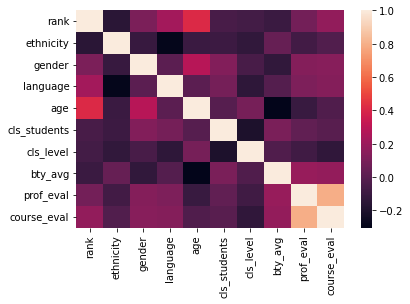

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


corr = df_num.corr()
print(corr)
sns.heatmap(corr)

## 3. Decision Tree: numeric dataset
### 3.1. Using our custom CART algorithm

In [23]:
data_rows = df_num.to_numpy().tolist()

In [24]:
columns_list = df_num.columns.to_numpy().tolist()

This would be a regression tree, as we are trying to predict a numeric score. We have to use __variance__ as a measure of node purity.

In [25]:
tree = buildtree(data_rows, score_func=variance, min_improvement=0, min_samples=10)

In [26]:
print_tree(tree, '', columns_list)

prof_eval: >=3.8? 
  T->prof_eval: >=4.8? 
    T->cls_students: >=39.0? 
      T->{4.0: '50%', 5.0: '50%'}
      F->cls_level: >=2.0? 
        T->{5.0: '78%', 4.0: '21%'}
        F->prof_eval: >=4.9? 
          T->{5.0: '100%'}
          F->{5.0: '90%', 4.0: '9%'}
    F->prof_eval: >=4.6? 
      T->cls_students: >=27.0? 
        T->prof_eval: >=4.7? 
          T->{4.0: '84%', 5.0: '15%'}
          F->{4.0: '100%'}
        F->cls_students: >=19.0? 
          T->{4.0: '15%', 5.0: '84%'}
          F->{4.0: '72%', 5.0: '27%'}
      F->prof_eval: >=3.9? 
        T->cls_students: >=21.0? 
          T->bty_avg: >=4.833? 
            T->rank: >=2.0? 
              T->bty_avg: >=5.167? 
                T->{4.0: '100%'}
                F->{4.0: '91%', 3.0: '8%'}
              F->{4.0: '80%', 3.0: '20%'}
            F->{4.0: '100%'}
          F->prof_eval: >=4.3? 
            T->bty_avg: >=4.333? 
              T->{4.0: '92%', 5.0: '7%'}
              F->{4.0: '83%', 5.0: '16%'}
            F->{4

### 3.2. Using sklearn library
The decision tree algorithm in sklearn library is not implemented very well. It requires all the attributes to be numeric - while decision trees work best with the categorical attributes. Nevertheless, we will try to run it and compare the results.

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn import tree

The class label has to be binary. So we are going to replace the 'course_eval' column with 3 bins, corresponding to the score:

Divide dataset into features and class label.

In [54]:
X = df_num.loc[:, df_num.columns != 'course_eval']
print(X.columns)

Y = df_num.loc[:, df_num.columns == 'course_eval']
print(Y.columns)

Index(['rank', 'ethnicity', 'gender', 'language', 'age', 'cls_students',
       'cls_level', 'bty_avg', 'prof_eval'],
      dtype='object')
Index(['course_eval'], dtype='object')


Split dataset intro training and testing.

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0)

Different parameters can be specified to build the model:

`model = tree.DecisionTreeClassifier(
        criterion='entropy', 
        max_depth=None, 
        min_samples_split=2, 
        min_samples_leaf=1, 
        max_features=None, 
        random_state=None, 
        min_density=None, 
        compute_importances=None, 
        max_leaf_nodes=None)`

In [56]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 4)
model.fit(X_train,Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7)

In [91]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 4)
model.fit(X_train,Y_train)
columns_list = df_num.columns.to_numpy().tolist()
from sklearn.tree import export_text
r = export_text(model, feature_names=columns_list[:-1])
print(r)
predictdf = pd.read_csv("C:/Users/10705/Desktop/Notebooks/labs_ml_optimizations/predict.csv")
testpredict = model.predict([[2,0,2,1,70,12,2,5,3],[1,0,1,1,35,50,2,7,5],[1,0,1,1,50,25,2,5,4]])
print(testpredict)


|--- prof_eval <= 3.75
|   |--- prof_eval <= 3.45
|   |   |--- prof_eval <= 2.60
|   |   |   |--- class: 2
|   |   |--- prof_eval >  2.60
|   |   |   |--- bty_avg <= 5.83
|   |   |   |   |--- class: 3
|   |   |   |--- bty_avg >  5.83
|   |   |   |   |--- class: 3
|   |--- prof_eval >  3.45
|   |   |--- age <= 48.00
|   |   |   |--- cls_students <= 93.50
|   |   |   |   |--- class: 3
|   |   |   |--- cls_students >  93.50
|   |   |   |   |--- class: 4
|   |   |--- age >  48.00
|   |   |   |--- cls_students <= 110.00
|   |   |   |   |--- class: 4
|   |   |   |--- cls_students >  110.00
|   |   |   |   |--- class: 3
|--- prof_eval >  3.75
|   |--- prof_eval <= 4.55
|   |   |--- cls_students <= 20.50
|   |   |   |--- prof_eval <= 4.25
|   |   |   |   |--- class: 4
|   |   |   |--- prof_eval >  4.25
|   |   |   |   |--- class: 4
|   |   |--- cls_students >  20.50
|   |   |   |--- rank <= 1.50
|   |   |   |   |--- class: 4
|   |   |   |--- rank >  1.50
|   |   |   |   |--- class: 4
|   |--- 

In [92]:
from sklearn import tree
tree.export_graphviz(model,out_file='tree.txt')

## 4. Categorical dataset

We are going to replace all the numeric columns in _df_ by categorical labels, using [Pandas _cut_ method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html).

First we create a copy of the original dataset.

In [32]:
df_cat = df.copy()

In [33]:
print(df_cat.columns)
print(df_cat[:5])

Index(['rank', 'ethnicity', 'gender', 'language', 'age', 'cls_students',
       'cls_level', 'bty_avg', 'prof_eval', 'course_eval'],
      dtype='object')
           rank     ethnicity  gender language  age  cls_students cls_level  \
0  tenure track      minority  female  english   36            43     upper   
1  tenure track      minority  female  english   36           125     upper   
2  tenure track      minority  female  english   36           125     upper   
3  tenure track      minority  female  english   36           123     upper   
4       tenured  not minority    male  english   59            20     upper   

   bty_avg  prof_eval  course_eval  
0      5.0        4.7          4.3  
1      5.0        4.1          3.7  
2      5.0        3.9          3.6  
3      5.0        4.8          4.4  
4      3.0        4.6          4.5  


We need to bin columns 'age', 'cls_students', 'bty_avg', 'prof_eval', and 'course_eval'. Everything else is already categorical.

First thing is to determine the domain for each numeric column.

In [34]:
# Age
age_column = df_cat["age"]
print("From:", age_column.min(), "to", age_column.max())

From: 29 to 73


In [35]:
# Beauty score
bty_ave_column = df_cat["bty_avg"]
print("From:", bty_ave_column.min(), "to", bty_ave_column.max())

From: 1.667 to 8.167


In [36]:
# Class size
num_students_column = df_cat["cls_students"]
print("From:", num_students_column.min(), "to", num_students_column.max())

From: 8 to 581


In [37]:
# Professor score
prof_eval_column = df_cat["prof_eval"]
print("From:", prof_eval_column.min(), "to", prof_eval_column.max())

From: 2.3 to 5.0


In [38]:
# Course score (class label)
course_eval_column = df_cat["course_eval"]
print("From:", course_eval_column.min(), "to", course_eval_column.max())

From: 2.1 to 5.0


In [39]:
import numpy as np

# Age to bins
bins = [20, 35, 50, 65, np.inf]
names = [ '20-35', '35-50',  '50-65', '65+']

df_cat['age'] = pd.cut(df_cat['age'], bins, labels=names)

# Class size to bins
bins = [0, 15, 30, 50, 100, np.inf]
names = [ '<15', '15-30',  '30-50', '50-100', '100+']

df_cat['cls_students'] = pd.cut(df_cat['cls_students'], bins, labels=names)

# Beauty average to bins
bins = [0, 3, 6, 9, np.inf]
names = [ '<3', '3-6',  '6-9', '9+']

df_cat['bty_avg'] = pd.cut(df_cat['bty_avg'], bins, labels=names)

# Professor score to bins
bins = [0, 2, 3, 4, 4.5, np.inf]
names = [ '<2', '2-3',  '3-4', '4-4.5', '4.5+']

df_cat['prof_eval'] = pd.cut(df_cat['prof_eval'], bins, labels=names)

# Course score to class label
bins = [0, 2, 3, 4, 4.5, np.inf]
names = [ 'bad', 'fair',  'average', 'good', 'excellent']

df_cat['course_eval'] = pd.cut(df_cat['course_eval'], bins, labels=names)


In [40]:
print(df_cat.columns)
print(df_cat[:5])

Index(['rank', 'ethnicity', 'gender', 'language', 'age', 'cls_students',
       'cls_level', 'bty_avg', 'prof_eval', 'course_eval'],
      dtype='object')
           rank     ethnicity  gender language    age cls_students cls_level  \
0  tenure track      minority  female  english  35-50        30-50     upper   
1  tenure track      minority  female  english  35-50         100+     upper   
2  tenure track      minority  female  english  35-50         100+     upper   
3  tenure track      minority  female  english  35-50         100+     upper   
4       tenured  not minority    male  english  50-65        15-30     upper   

  bty_avg prof_eval course_eval  
0     3-6      4.5+        good  
1     3-6     4-4.5     average  
2     3-6       3-4     average  
3     3-6      4.5+        good  
4      <3      4.5+        good  


## 5. Decision Tree: categorical dataset

In [41]:
data_rows = df_cat.to_numpy().tolist()

In [42]:
columns_list = df_cat.columns.to_numpy().tolist()

Now this is a decision tree (classification), we use entropy as a measure of leaf purity.

In [94]:
tree = buildtree(data_rows, score_func=entropy, min_improvement=0, min_samples=30)

In [95]:
print_tree(tree, '', columns_list)

prof_eval: 4.5+? 
  T->cls_students: 15-30? 
    T->{'good': '19%', 'excellent': '80%'}
    F->gender: male? 
      T->{'good': '51%', 'excellent': '46%', 'average': '2%'}
      F->{'good': '61%', 'average': '6%', 'excellent': '32%'}
  F->prof_eval: 4-4.5? 
    T->cls_students: 30-50? 
      T->{'average': '56%', 'good': '43%'}
      F->cls_level: upper? 
        T->age: 50-65? 
          T->{'average': '25%', 'good': '72%', 'excellent': '2%'}
          F->{'average': '40%', 'good': '52%', 'excellent': '7%'}
        F->{'average': '41%', 'good': '58%'}
    F->ethnicity: not minority? 
      T->bty_avg: <3? 
        T->{'fair': '25%', 'average': '74%'}
        F->gender: female? 
          T->{'average': '81%', 'fair': '18%'}
          F->{'average': '93%', 'fair': '6%'}
      F->{'average': '84%', 'fair': '12%', 'good': '3%'}


This is the best we could do for this dataset.

## 6. [TASK 1] Using learned tree for classification

Recall at least 3 different courses you have taken, and record the values of the attributes, and the course score that you have given to the course. Run the predict function to see if the decision tree correctly predicts your score.

I am thinking about three lessons with the following attributes in numeric values:[2,0,2,1,70,12,2,5,3], [1,0,1,1,35,50,2,7,5],[1,0,1,1,50,25,2,5,4]. It means that the first one is taught by a old male professor that is of average beauty, small class size, and moderate professor evaluation. The second one is a younger female assistant prof in a large class, with above average beauty and good prof evaluation. The third one is a older assistant prof that is having a moderate size class and is having average beauty and fine evaluation. The result in my mind is 3,5,4, yet the predict is 3,4,4 which underestimated the score. This is probably because there is no score 5 available as the scores are at most 4 as the evaluation is of type int, or the training set is flawed, just some possible reasons

## 7. [TASK 2] Important factors
What are the most important attributes in separating good course evaluations from the bad ones? Support your answer by analyzing the tree levels and the leaf outcomes.

I tried to use the graphviz to see the tree for sklearn method, and by limiting the tree height to be 4, the result shows that out of 14 total non-leaf nodes, 6 of them are about prof evaluation, which is consistent with the result from evaluation, and as the node fully determines the first two layer, as well as 2 out of 7 non-leaf nodes in the fourth layer, I think the prof evaluation is important. Out of 15 total leaves, 5 are directly related to prof evaluation, and generally, by looking closely at layer 2, if prof eval > 3.75, the course is much more likely to have a score higher than 3. Other than that, age and class size seems to also play a role in splitting the evaluation but it is less important than prof evaluation. It seems that if the prof is too young and the prof eval is less than 3.75, the course is more likely to have a lower score, while if the prof eval is greater than 3.75, prof younder than 60 is more likely to get a score of 4.

## 8. [TASK 3] Rules
Extract from the tree at least 3 rules that you find most reliable. Did any of these rules surprise you?

I am mostly looking at categorical data with min size of 30.   
Rule1: if prof evaluation is higher than 4.55, the class size is between 15-30, then the course evaluation score is guaranteed to be larger or equal to 4.    
Rule2: if prof evaluation is lower than 4, and class size is not between 30-50, and the prof is not minority, the course score is between 2 and 4.   
Rule3:if prof evaluation is less than 4, and the professor is not minority, and the professor has beauty score greater or equal to 3, the course evaluation is highly likely to be average, and is guaranteed to be either average or fair.

## 9. [BONUS] Web visualization
The visualizations of the tree can be made much more expressive with the _d3.js_ visualization library. Sample  _public_html_ folder containing all the required html, css, and javascript files, including the library itself, is provided. 

In order to create this visualization, all you need is a json file which represents the nodes of the final decision tree. Learn the required JSON format, and implement this conversion in a separate file __dtree_to_json.py__. Submit your file with the lab. 

Copy the resulting json file into the data directory in the _public_html_ folder, and update the name of the json file in the JavaScript code on line 39 in _index.html_. 

Note that Chrome would not allow you to run the visualization locally - so if you want to present it to the world you should use a web server. 


Copyright &copy; 2020 Marina Barsky. All rights reserved.

https://chance.amstat.org/2013/04/looking-good/

https://chance.amstat.org/2013/04/looking-good/